# XGBoost for Airline Time Series

In [1]:
from xgboost import XGBRegressor
from sktime.datasets import load_airline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from utils import change_df, prediction, fit_predict
import warnings
warnings.filterwarnings('ignore')

/home/nick/apps/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Load of dataset for XGBoost
df = load_airline()
df = df.reset_index()
names = ['Period', 'Number of airline passengers']
new_names = ['period', 'number']
# Renaming the columns of the dataset
df = df.rename(columns={names[0]:new_names[0], names[1]:new_names[1]})
df.period = df.period.astype('str')
df.period = pd.to_datetime(df.period, format='%Y-%m')
# Splitting the data to train and validation sets
y_validate = df.iloc[90:]
y = df.iloc[:90]

Text(0, 0.5, 'Number of passengers')

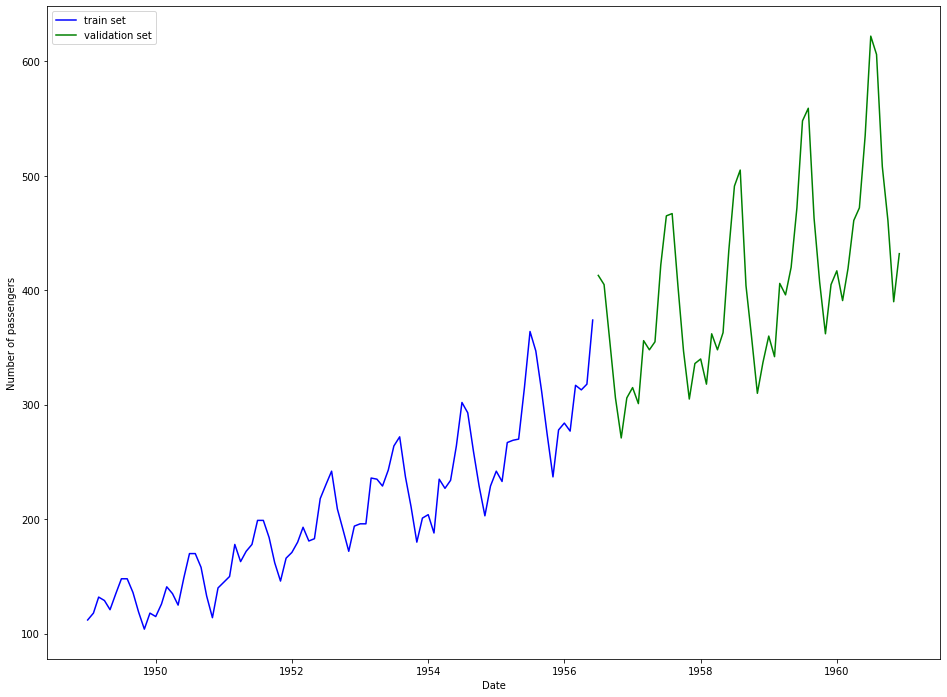

In [3]:
# Visualisation of train and validation datasets
plt.figure(figsize=(16,12))
plt.plot(y.period, y.number, label='train set', c='b')
plt.plot(y_validate.period, y_validate.number, label='validation set', c='g')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Number of passengers')

In [4]:
# Splitting the data from train dataset into 5 folders for cross-validation
tscv = TimeSeriesSplit(n_splits=5)
cv = [ (i[0], i[1]) for i in tscv.split(y)]

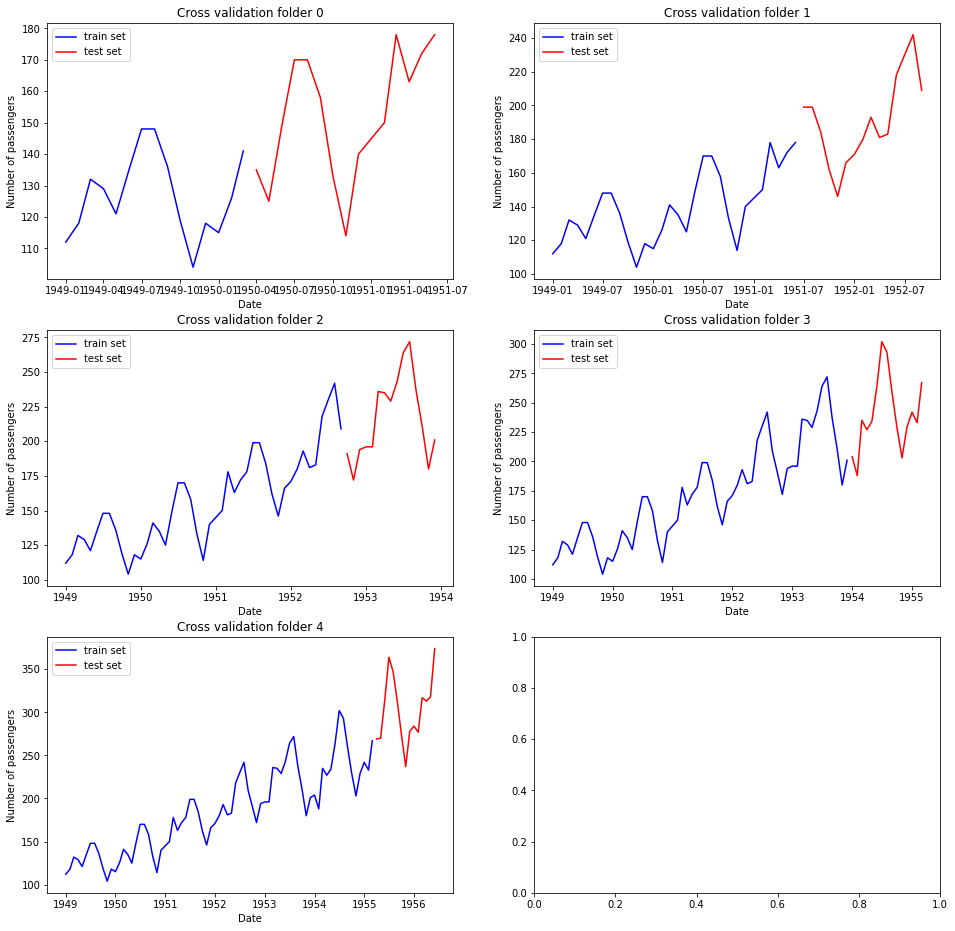

In [5]:
# Visualisation of cross-validation folders
fig, ax = plt.subplots(3,2, figsize=(16,16))
ax = ax.flatten()
for ind, (train, test) in enumerate(cv):
    ax[ind].plot(y.period[train], y.number[train], label='train set', c='b')
    ax[ind].plot(y.period[test], y.number[test], label='test set', c='r')
    ax[ind].set_xlabel('Date')
    ax[ind].set_ylabel('Number of passengers')
    ax[ind].legend()
    ax[ind].set_title('Cross validation folder {0}'.format(ind))

In order to show perfomance of XGBoost different types of data on which XGBoost was trained:
* data containing only time data
* data containing only lags
* data containing lags and time data

But further in the notebook, will be shown, that even if lag time data was created on real past data and not on predicted past data XGBoost cannot forecast acceptable results.

# Prediction using only time data

In [10]:
models = []

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 5.46 s, sys: 49.4 ms, total: 5.51 s
Wall time: 797 ms


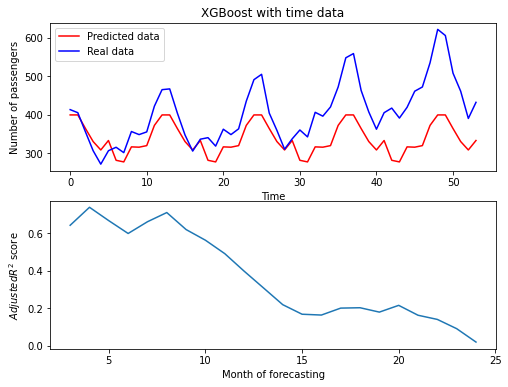

In [11]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=True, lag=False, name='XGBoost with time data'))

# Prediction using only lags

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 7.21 s, sys: 36.2 ms, total: 7.25 s
Wall time: 1.01 s


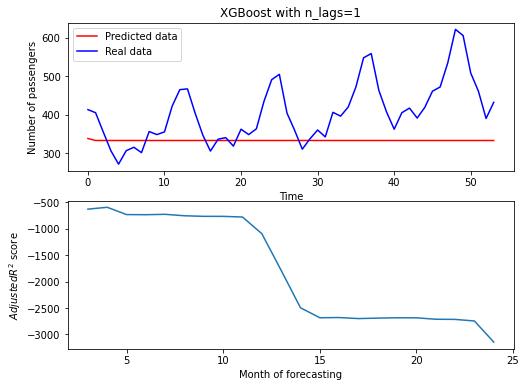

In [12]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=False, lag=True, name='XGBoost with n_lags=1'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 6.49 s, sys: 31.5 ms, total: 6.52 s
Wall time: 873 ms


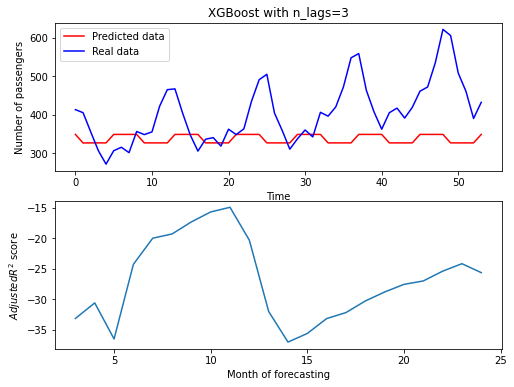

In [13]:
%time models.append(fit_predict(y, y_validate, num_lags=4,time=False, lag=True, name='XGBoost with n_lags=3'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 10.2 s, sys: 84.9 ms, total: 10.3 s
Wall time: 1.45 s


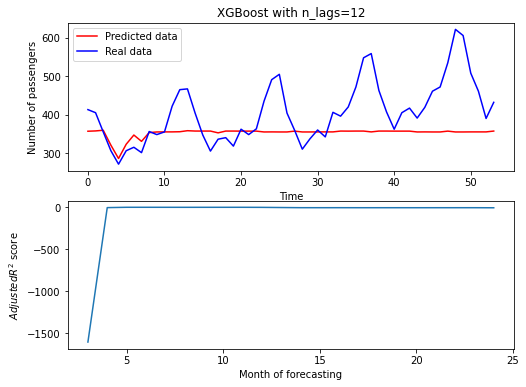

In [14]:
%time models.append(fit_predict(y, y_validate, num_lags=13,time=False, lag=True, name='XGBoost with n_lags=12'))

# Prediction using time and lags data

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 6.96 s, sys: 54.9 ms, total: 7.01 s
Wall time: 953 ms


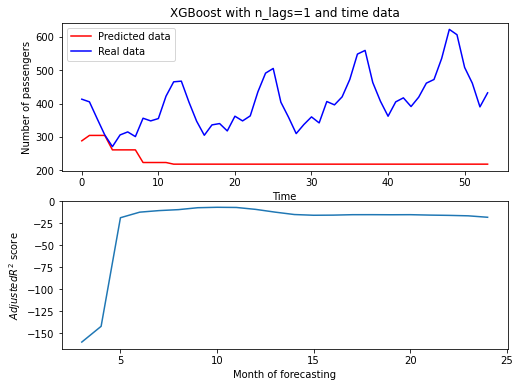

In [15]:
%time models.append(fit_predict(y, y_validate, num_lags=2,time=True, lag=True, name='XGBoost with n_lags=1 and time data'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 7.37 s, sys: 29.2 ms, total: 7.4 s
Wall time: 1 s


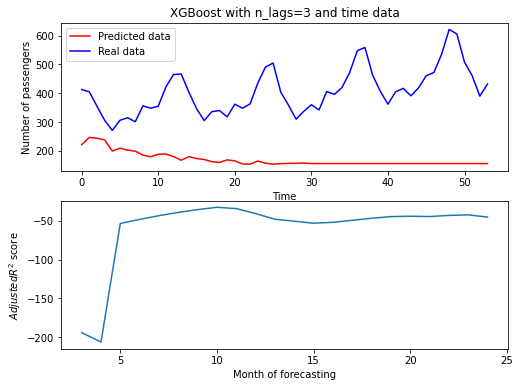

In [16]:
%time models.append(fit_predict(y, y_validate, num_lags=4,time=True, lag=True, name='XGBoost with n_lags=3 and time data'))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 8.03 s, sys: 40.7 ms, total: 8.07 s
Wall time: 1.08 s


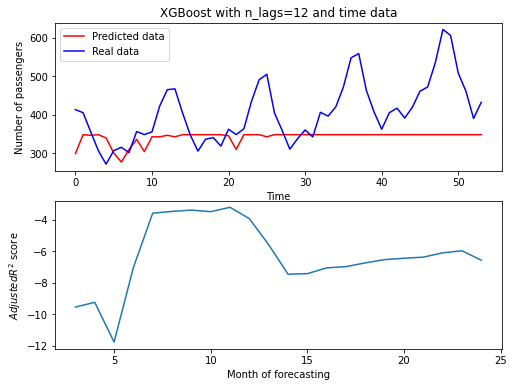

In [17]:
%time models.append(fit_predict(y, y_validate, num_lags=13,time=True, lag=True, name='XGBoost with n_lags=12 and time data'))

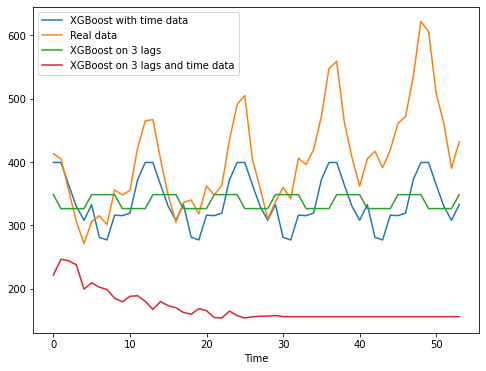

In [18]:
plt.figure(figsize=(8,6))
plt.plot(models[0][1], label='XGBoost with time data')
plt.plot(y_validate.number.to_numpy(), label='Real data')
plt.plot(models[2][1], label='XGBoost on 3 lags')
plt.plot(models[5][1], label='XGBoost on 3 lags and time data')
plt.xlabel('Time')
plt.legend()

As a result of fitting XGboost with different data we may observe certain dependencies:
* XGBoost trained only on time data can learn seasonality of data, but cannot learn trend of the data.
* XGBoost trained only on lag cannot restore dependencies even when predicting on real values lags.
* XGBoost trained on time and lag datacannot restore dependencies even when predicting on real values lags.